In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from math import log2
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

In [3]:
def mlp (inputs,config_dict):
    
    mlp = L.Dense(config_dict['mlp_dim'],activation = 'gelu')(inputs)
    mlp = L.Dropout(config_dict['dropout'])(mlp)
    mlp = L.Dense(config_dict['hidden_dim'], activation = 'gelu')(mlp)
    mlp = L.Dropout(config_dict['dropout'])(mlp)

    return mlp

In [4]:
def conv(inputs,filters,kernel = 3):
    
    conv = L.Conv2D(filters,kernel_size = kernel,padding = 'same')(inputs)
    conv = L.BatchNormalization()(conv)
    conv = L.ReLU()(conv)

    return conv

In [5]:
def deconv (inputs,filters,strides = 2):
    deconv = L.Conv2DTranspose(filters,kernel_size = 2, padding = 'same',strides = strides)(inputs)

    return deconv

In [6]:
# making function of Transformer Encoder
def trans_encoder(inputs,config_dict):
    residue_1 = inputs
    
    encode = L.LayerNormalization()(inputs)
    encode = L.MultiHeadAttention(
        num_heads = config_dict['heads'], key_dim = config_dict['hidden_dim']
    )(encode,encode)

    encode = L.Add()([encode,residue_1])
    
    residue_2 = encode

    
    encode = L.LayerNormalization()(encode)
    encode = mlp(encode,config_dict)

    encode = L.Add()([encode,residue_2])

    return encode
    

In [7]:
def Trans_Unet_2D(config_dict):
    # Here we will define Inputs

    input_shape = (config_dict['num_patches'],config_dict['patch_size'] * config_dict['patch_size'] * config_dict['num_channels'])
    inputs = L.Input(input_shape) #
    #print('Inputs shape',inputs.shape)
    ### Patch + Position Embedding ####
    patch_embedding = L.Dense(config_dict['hidden_dim'])(inputs)
        #print('Patch',patch_embedding)
    positions = tf.range(start = 0,limit = config_dict['num_patches'],delta = 1)
        #print('Positions',positions)
    position_embedding = L.Embedding(input_dim = config_dict['num_patches'],output_dim = config_dict['hidden_dim'])(positions)
        #print('Position Embeddings',position_embedding)
    x = patch_embedding + position_embedding
    #print('patch + position',x)

    ### The Transformer Encoder ###
    skip_connection_index = [3,6,9,12]
    skip_connections = []
 # Now we extract the layers in index 3,6,9 and 12 as skip connections
    for i in range(1,config_dict['num_layers']+1,1):
        x = trans_encoder(x,config_dict)

        if i in skip_connection_index:
            skip_connections.append(x)

    ## Now Defining CNN Decoder

    z3,z6,z9,z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((config_dict['image_size'],config_dict['image_size'],config_dict['num_channels']))(inputs)

    shape = (
        config_dict['image_size'] // config_dict['patch_size'],
        config_dict['image_size'] // config_dict['patch_size'],
        config_dict['hidden_dim']
    )
   
    z3 = L.Reshape(shape)(z3)
    z6 = L.Reshape(shape)(z6)
    z9 = L.Reshape(shape)(z9)
    z12 = L.Reshape(shape)(z12)
    print('z3 shape', z3.shape)
    ## Additional Layers for managing different Patch Sizes

    total_upscale_factor = int(log2(config_dict['patch_size']))
    upscale = total_upscale_factor - 4
    print('upscale factor',upscale)
    if upscale >=2:  ## Patch Size 16 or greater
        z3 = deconv(z3,z3.shape[-1], strides = 2**upscale)
        z6 = deconv(z6,z6.shape[-1], strides = 2**upscale)
        z9 = deconv(z9,z9.shape[-1], strides = 2**upscale)
        z12 = deconv(z12,z12.shape[-1],strides = 2**upscale)

    if upscale < 0: ## Patch_size smaller than 16
        p = 2**abs(upscale)
        z3 = L.MaxPool2D((p,p))(z3)
        z6 = L.MaxPool2D((p,p))(z6)
        z9 = L.MaxPool2D((p,p))(z9)
        z12 = L.MaxPool2D((p,p))(z12)

    ## Decoder 1
    x = deconv(z12,128)

    s = deconv(z9,128)
    s = conv(s,128)

    x = L.Concatenate()([x,s])

    x = conv(x,128)
    x = conv(x,128)


    ## Decoder 2

    x = deconv(x,64)

    s = conv(z6,64)
    s = deconv(s,64)
    s = deconv(s,64)
    s = conv(s,64)

    x = L.Concatenate()([x,s])

    x = conv(x,64)
    x = conv(x,64)

    ## Decoder 3

    x = deconv(x,32)

    s = deconv(z3,32)
    s = conv(s,32)
    s = deconv(s,32)
    s = conv(s,32)
    s = deconv(s,32)
    s = conv(s,32)

    x = L.Concatenate()([x,s])

    x = conv(x,32)
    x = conv(x,32)

    ## Decoder 4
    
    x = deconv(x,16)

    s = conv(z0,16)
    s = conv(s,16)

    x = L.Concatenate()([x,s])
    x = conv(x,16)
    x = conv(x,16)

    ## Output
    outputs = L.Conv2D(1,kernel_size = 1, padding= 'same', activation = 'sigmoid')(x)

    return Model(inputs,outputs, name = 'UNETR_2D')

In [8]:
if __name__=="__main__":
    config_dict = {}
    
    config_dict["num_layers"] =  12
    config_dict['image_size'] = 512
    config_dict['hidden_dim'] = 64
    config_dict['mlp_dim'] = 128
    config_dict['heads'] = 6
    config_dict['dropout'] = 0.1
    config_dict['patch_size'] = 1
    config_dict['num_patches'] = (config_dict['image_size']**2)//(config_dict['patch_size'])
    config_dict['num_channels'] = 3
    

In [9]:
 Trans_Unet_2D(config_dict)

z3 shape (None, 512, 512, 64)
upscale factor -4


<Functional name=UNETR_2D, built=True>

# Training The UNETR

In [10]:
!pip install patchify

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [11]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from patchify import patchify
#from unetr_2d import build_unetr_2d
#from metrics import dice_loss, dice_coef

In [12]:
cf = {}
cf['num_layers'] = 12
cf['image_size'] = 256
cf['num_channels'] = 3
cf['hidden_dim'] = 128
cf['mlp_dim'] = 32
cf['heads'] = 6
cf['dropout'] = 0.1
cf['patch_size'] = 16
cf['num_patches'] = (cf['image_size']**2) // (cf['patch_size']**2)
cf['flat_patches_shape'] = (cf['num_patches'], cf['patch_size']*cf['patch_size']*cf['num_channels'])

In [13]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [14]:
def load_dataset(path,split = 0.1):
    # Load the images
    X = sorted(glob(os.path.join(path,'images','*.png')))
    Y = sorted(glob(os.path.join(path,'masks','*.png')))

    # Splitting the Dataset into Training and Testing
    split_size = int(len(X)*split)
    
    train_x,valid_x = train_test_split(X,test_size = split_size,random_state = 16)
    train_y,valid_y = train_test_split(Y, test_size = split_size, random_state = 16)
    
    return (train_x,train_y), (valid_x,valid_y)

In [15]:
def read_image(path):
    path = path.decode()
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img,(cf['image_size'],cf['image_size']))
    img = img / 255.0

    ## Processing The patches

    patch_shape = (cf['patch_size'],cf['patch_size'],cf['num_channels'])
    patches = patchify(img,patch_shape,cf['patch_size'])
    patches = np.reshape(patches, cf['flat_patches_shape'])
    patches = patches.astype(np.float32)

    return patches

In [16]:
def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask,(cf['image_size'],cf['image_size']))
    mask = mask/255.0

    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask,axis = -1)

    return mask

In [17]:
def tf_parse(x,y):
    def _parse(x,y):
        x = read_image(x)
        y = read_mask(y)
        return x,y
    x,y = tf.numpy_function(_parse,[x,y],[tf.float32,tf.float32])
    x.set_shape(cf['flat_patches_shape'])
    y.set_shape((cf['image_size'],cf['image_size'],1))
    return x,y

In [18]:
def tf_dataset(X,Y,batch = 2):
    dataset = tf.data.Dataset.from_tensor_slices((X,Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)

    return dataset

In [19]:
if __name__ == "__main__":

    """ Seeding """
    np.random.seed(16)
    tf.random.set_seed(16)

    ## Directory for stroing files
    create_dir('files')

    # Hyper Parametrs
    batch_size = 8
    learning_rate = 0.1
    epochs = 50


    # Dataset
    dataset_path = '/kaggle/input/brain-tumor-segmentation/'
    (train_x,train_y),(valid_x,valid_y) = load_dataset(dataset_path)
    

In [20]:
train_dataset = tf_dataset(train_x,train_y,batch = batch_size)

In [21]:
len(train_dataset)

345

In [22]:
valid_dataset = tf_dataset(valid_x,valid_y, batch = batch_size)

In [23]:
len(valid_dataset)

39

In [24]:
import numpy as np
import tensorflow as tf

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [25]:
model =  Trans_Unet_2D(cf)
model.compile(loss = dice_loss,optimizer = SGD(learning_rate),metrics = [dice_coef,'accuracy'])

z3 shape (None, 16, 16, 128)
upscale factor 0


In [26]:
    callbacks = [
        #ModelCheckpoint('/kaggle/working/', verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        #CSVLogger("/kaggle/working/"),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

    model.fit(
        train_dataset,
        epochs=100,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Epoch 1/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 125s 230ms/step - accuracy: 0.7147 - dice_coef: 0.0445 - loss: 0.9555 - val_accuracy: 0.4009 - val_dice_coef: 0.0469 - val_loss: 0.9528 - learning_rate: 0.1000
Epoch 2/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.8588 - dice_coef: 0.1154 - loss: 0.8846 - val_accuracy: 0.8566 - val_dice_coef: 0.1197 - val_loss: 0.8789 - learning_rate: 0.1000
Epoch 3/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9733 - dice_coef: 0.2495 - loss: 0.7505 - val_accuracy: 0.9675 - val_dice_coef: 0.2549 - val_loss: 0.7403 - learning_rate: 0.1000
Epoch 4/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.9795 - dice_coef: 0.3456 - loss: 0.6544 - val_accuracy: 0.9851 - val_dice_coef: 0.2811 - val_loss: 0.7134 - learning_rate: 0.1000
Epoch 5/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.9816 - dice_coef: 0.3993 - loss: 0.6007 - val_accuracy: 0.9853 - val_dice_coef: 0.2468 - val_loss: 0.7484 - learning_rate: 0.1000
Epo

In [27]:
model.save('UNETR_Brain_Tumor.h5')

# Testing The Model

In [28]:
import os


import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
from patchify import patchify
#from train import load_dataset, create_dir
#from metrics import dice_loss, dice_coef

In [29]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(16)
    tf.random.set_seed(16)


    create_dir(f"results")

    model  = model

In [30]:
for x,y in tqdm(zip(valid_x,valid_y),total = len(valid_x)):  
    # Extracting the name
    name = x.split('/')[-1]

    img  = cv2.imread(x,cv2.IMREAD_COLOR)
    img = cv2.resize(img,(256,256))
    x  = img/255.0
    # Read Image
    patch_shape = ((cf['patch_size'],cf['patch_size'],cf['num_channels']))
    patches = patchify(x,patch_shape,cf['patch_size'])
    patches = np.reshape(patches,cf['flat_patches_shape'])
    patches = patches.astype(np.float32)
    patches = np.expand_dims(patches,axis = 0)

    # Read Mask
    mask = cv2.imread(y,cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask,(256,256))
    mask = mask/255.0

    mask = np.expand_dims(mask,axis = -1)
    mask = np.concatenate([mask,mask,mask],axis = -1)

    # Predict
    pred = model.predict(patches,verbose=0)[0]
    pred = np.concatenate([pred,pred,pred],axis = -1)

    """Save the fianl Mask"""
    line = np.ones((cf['image_size'],10,3))*255
    #cat_images = np.concatenate([img,line,mask*255,line,pred*255])
    save_image_path = os.path.join('/kaggle/working/results',name)
    
    cv2.imwrite(save_image_path,pred)


100%|██████████| 306/306 [00:27<00:00, 11.11it/s]


In [31]:
import matplotlib.pyplot as plt    

In [44]:
pred_mask = cv2.imread('/kaggle/working/results/1002.png',0)

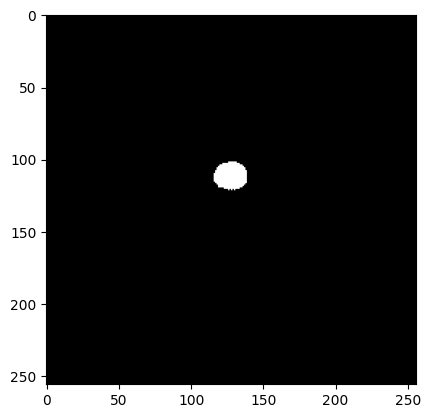

In [45]:
plt.imshow(pred_mask,cmap = 'gray')

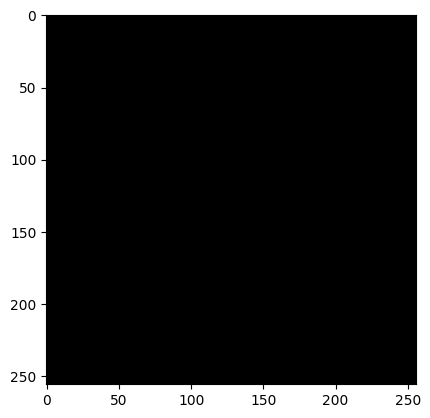

In [46]:
plt.imshow(pred,cmap = 'gray')

In [75]:
image = cv2.imread('/kaggle/working/results/202.png',0)

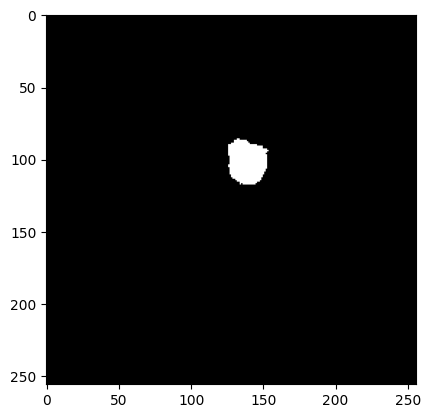

In [76]:
image = np.array(image, dtype=float)
plt.imshow(image,cmap= 'gray')

In [73]:
img = cv2.imread('/kaggle/input/brain-tumor-segmentation/images/202.png',0)


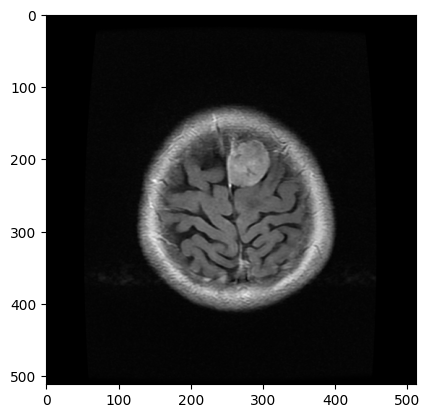

In [74]:
plt.imshow(img,cmap = 'gray')